<a href="https://colab.research.google.com/github/bobyuwono/-bobyuwono-.github.io/blob/master/Dojo_Demo_CPU%20%209%20februari.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



# **importing library**



In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

print(tf.__version__)

import numpy as np
import matplotlib.pyplot as plt

2.7.0


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
  plt.plot(time[start:end], series[start:end], format)
  plt.xlabel("Time")
  plt.ylabel("value")
  plt.grid(True)

## download dataset

In [3]:
!wget --no-check-certificate \
   https://storage.googleapis.com/dojo-vault-123/cpu-full-a.csv \
    -O /tmp/cpu.csv

--2022-02-09 01:38:56--  https://storage.googleapis.com/dojo-vault-123/cpu-full-a.csv
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.119.128, 108.177.111.128, 142.250.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.119.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12017 (12K) [text/csv]
Saving to: ‘/tmp/cpu.csv’

/tmp/cpu.csv        100%[===================>]  11.74K  --.-KB/s    in 0s      

2022-02-09 01:38:56 (87.9 MB/s) - ‘/tmp/cpu.csv’ saved [12017/12017]



visualiasi data


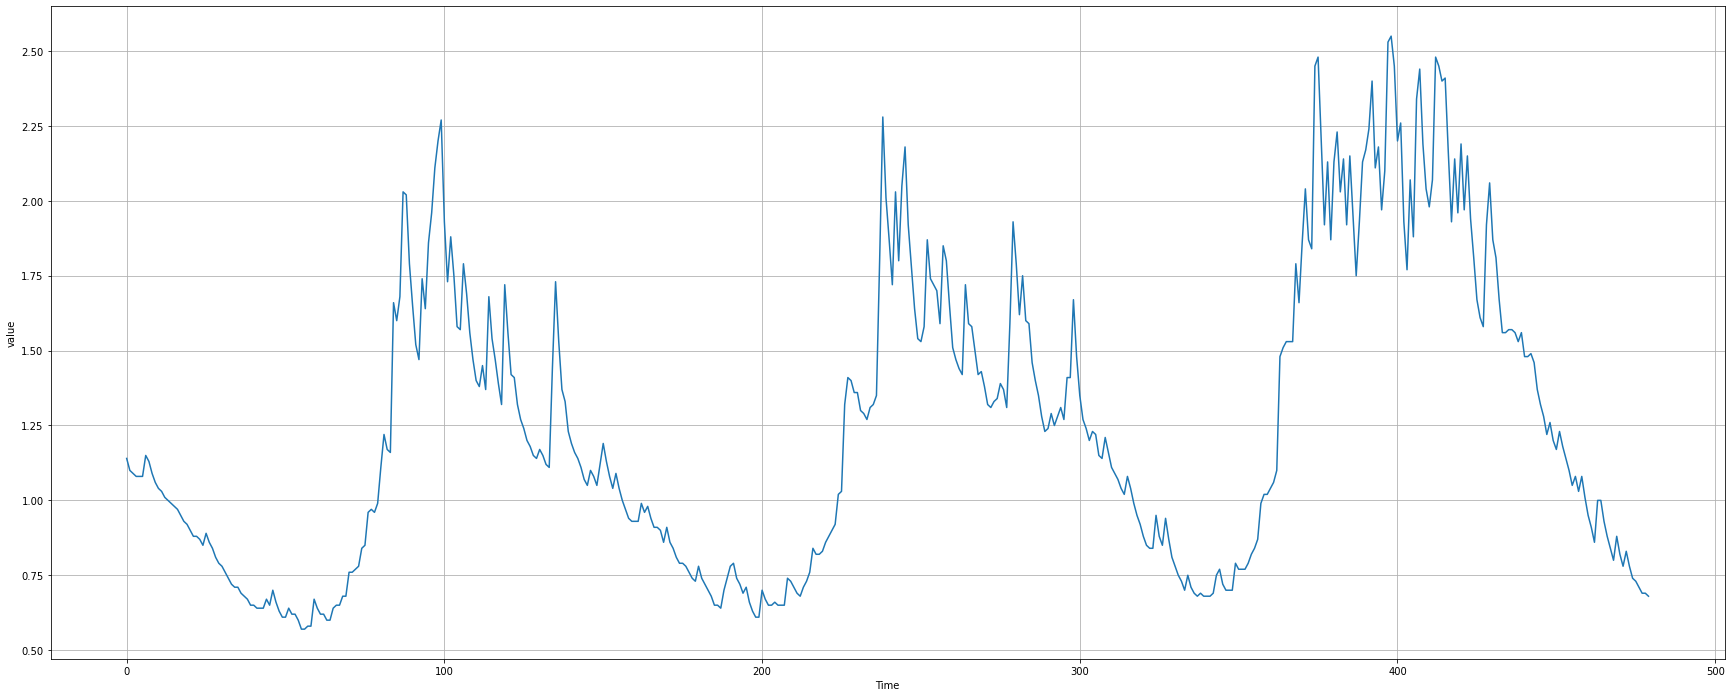

In [4]:
import csv
time_step = []
cpu_usage = []

with open('/tmp/cpu.csv') as csvfile:
  reader = csv.reader(csvfile, delimiter=',')
  next(reader)
  time_indicator=0
  for row in reader:
    cpu_usage.append(float(row[1]))
    # time = row[0].split()[1]
    time_step.append(time_indicator)
    time_indicator +=1

series = np.array(cpu_usage)
time = np.array(time_step)
plt.figure(figsize=(30,12))
plot_series(time,series)

In [5]:
# membagi data menjadi porsi untuk training dan validasi

split_time = 300

time_train = time[:split_time]
x_train = series[:split_time]

time_valid = time[split_time:]
x_valid = series[split_time:]

In [6]:
window_size=10
batch_size=32
shuffle_buffer_size=480

In [8]:
print(time_valid.shape)
print(x_valid.shape)
print(time_train.shape)

(180,)
(180,)
(300,)


In [9]:
def windowed_dataset(series, window_size,batch_size, shuffle_buffer):
  series = tf.expand_dims(series,axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  ds = ds.window(window_size + 1, shift=1 , drop_remainder=True)  # ubah data singular menjadi data berbentuk window, kemudian drop remainder yang tidak terpakai
  ds = ds.flat_map(lambda w:w.batch(window_size +1)) 
  ds = ds.shuffle(shuffle_buffer)           # data perlu di shuffle untuk mengurangi sequential bias
  ds = ds.map(lambda w: (w[:-1], w[1:]))    # split data menjadi Features dan Label
  return ds.batch(batch_size).prefetch(1)   # batch dataset seukuran batch_size

In [10]:
def model_forecast(model, series, window_size):
  ds = tf.data.Dataset.from_tensor_slices(series) 
  ds = ds.window(window_size, shift=1, drop_remainder=True)
  ds = ds.flat_map(lambda w: w.batch(window_size))
  ds = ds.batch(32).prefetch(1)
  forecast = model.predict(ds)
  return forecast

In [21]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [35]:
print(series[-1:])
print("hell")
resulto = model.predict(series[..., np.newaxis],1 )
print(resulto.shape)

[0.68]
hell
(480, 1, 1)


In [ ]:
forecast_x = model_forecast(model, series[-10:, np.newaxis], 10)

In [ ]:
print(forecast_x)

[[[0.8837021 ]
  [0.8681654 ]
  [0.8687491 ]
  [0.9277327 ]
  [0.8994026 ]
  [0.85716915]
  [0.8274908 ]
  [0.76843274]
  [0.76843274]
  [0.76843274]]]


In [36]:
dataset_x = tf.data.Dataset.from_tensor_slices(series[-10:])
dataset_x = tf.expand_dims(dataset_x,axis=-1)

model.predict(dataset_x)

ValueError: ignored

In [ ]:
def forecast_future (length, series, window_size=0):
  """
  1. predict one next step,
  2. append
  3. predict one more
  """
  for x in range(1, length+1):
    """
      1. misalkan nilai x adalah 1 hinga 10
      2. ulangi sebanyak x kali, untuk [windows] nilai cpu_usage terakhir, predict value [y]
    """
    dataset = tf.data.Dataset.from_tensor_slices(series[-window_size:])
    ds = dataset.flat_map(lambda w: w.batch(window_size))
    forecast = model.predict(ds)

    print("nilai ", x, " adalah")
    print(series[-x:])
  
forecast_future(10, series, window_size=10)

nilai  1  adalah
[0.68]
nilai  2  adalah
[0.69 0.68]
nilai  3  adalah
[0.69 0.69 0.68]
nilai  4  adalah
[0.71 0.69 0.69 0.68]
nilai  5  adalah
[0.73 0.71 0.69 0.69 0.68]
nilai  6  adalah
[0.74 0.73 0.71 0.69 0.69 0.68]
nilai  7  adalah
[0.78 0.74 0.73 0.71 0.69 0.69 0.68]
nilai  8  adalah
[0.83 0.78 0.74 0.73 0.71 0.69 0.69 0.68]
nilai  9  adalah
[0.78 0.83 0.78 0.74 0.73 0.71 0.69 0.69 0.68]
nilai  10  adalah
[0.82 0.78 0.83 0.78 0.74 0.73 0.71 0.69 0.69 0.68]


In [12]:
tf.keras.backend.clear_session()


tf.random.set_seed(51)
np.random.seed(51)

window_size = 10
batch_size = 32
train_set = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(train_set)
print("batas")
print(x_train.shape)

<PrefetchDataset shapes: ((None, None, 1), (None, None, 1)), types: (tf.float64, tf.float64)>
batas
(300,)


In [13]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                         strides=1, padding="causal",
                         activation="relu",
                         input_shape=[None,1]),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.LSTM(64, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x*400)
])

In [14]:
tf.keras.backend.clear_session()

lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch/20))
optimizer= tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=50, callbacks=[lr_schedule])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/50
10/10 [==============================] - 4s 23ms/step - loss: 0.5921 - mae: 0.9763 - lr: 1.0000e-08
Epoch 2/50
10/10 [==============================] - 0s 15ms/step - loss: 0.5616 - mae: 0.9367 - lr: 1.1220e-08
Epoch 3/50
10/10 [==============================] - 0s 16ms/step - loss: 0.5203 - mae: 0.8833 - lr: 1.2589e-08
Epoch 4/50
10/10 [==============================] - 0s 16ms/step - loss: 0.4782 - mae: 0.8316 - lr: 1.4125e-08
Epoch 5/50
10/10 [==============================] - 0s 17ms/step - loss: 0.4393 - mae: 0.7875 - lr: 1.5849e-08
Epoch 6/50
10/10 [==============================] - 0s 16ms/step - loss: 0.4034 - mae: 0.7471 - lr: 1.7783e-08
Epoch 7/50
10/10 [==============================] - 0s 18ms/step - loss: 0.3699 - mae: 0.7092 - lr: 1.9953e-08
Epoch 8/50
10/10 [==============================] - 0s 15ms/step - loss: 0.3376 - mae: 0.6716 - lr: 2.2387e-08
Epoch 9/50
10/10 [==============================] - 0s 16ms/step - loss: 0.3057 - mae: 0.6336 - lr: 2.5119e-08
E

(1e-08, 0.0001, 0.0, 20.0)

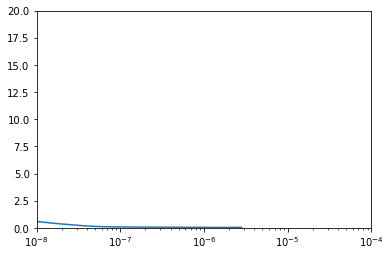

In [15]:
plt.semilogx(history.history["lr"], history.history["loss"])

plt.axis([1e-8, 1e-4, 0, 20])

In [16]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
train_set = windowed_dataset(x_train, window_size=10, batch_size=32, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=10, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.LSTM(60, return_sequences=True),
  tf.keras.layers.Dense(30, activation="relu"),
  tf.keras.layers.Dense(10, activation="relu"),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 400)
])


optimizer = tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9)

model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])

history = model.fit(train_set,epochs=100)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


Epoch 1/100
10/10 [==============================] - 4s 18ms/step - loss: 0.3751 - mae: 0.7516
Epoch 2/100
10/10 [==============================] - 0s 15ms/step - loss: 0.1977 - mae: 0.4855
Epoch 3/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1233 - mae: 0.3872
Epoch 4/100
10/10 [==============================] - 0s 14ms/step - loss: 0.1083 - mae: 0.3760
Epoch 5/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0936 - mae: 0.3344
Epoch 6/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0837 - mae: 0.3135
Epoch 7/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0753 - mae: 0.3004
Epoch 8/100
10/10 [==============================] - 0s 15ms/step - loss: 0.0654 - mae: 0.2709
Epoch 9/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0565 - mae: 0.2419
Epoch 10/100
10/10 [==============================] - 0s 14ms/step - loss: 0.0514 - mae: 0.2284
Epoch 11/100
10/10 [=============================

In [17]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
print(time_valid.shape)

(180,)


In [ ]:
print(time_valid[-10:])

[470 471 472 473 474 475 476 477 478 479]


In [ ]:
print(x_valid.shape)

(300,)


(180,)

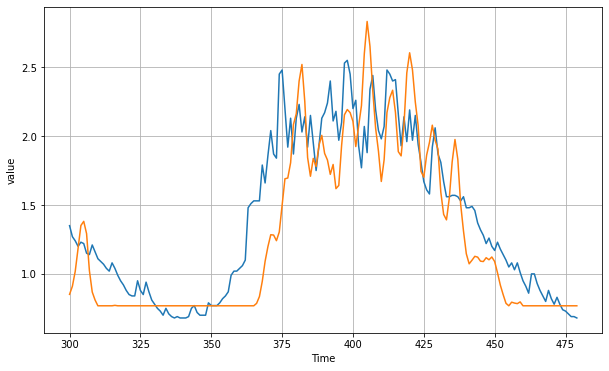

In [18]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
array_baru = np.arange(481,491)
print(array_baru)

[481 482 483 484 485 486 487 488 489 490]


BATAS AMAN. bawah masih eksperimen!

In [ ]:
series_2 = np.array(array_baru)

In [ ]:
forecast_baru = model_forecast(model, series  np.newaxis], window_size)

In [ ]:
forecast_baru.shape

(471, 10, 1)

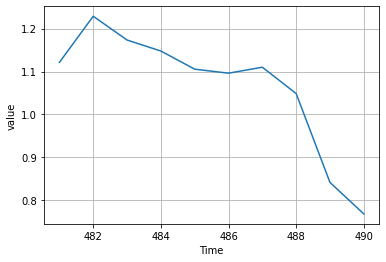

In [ ]:
plot_series(array_baru, forecast_baru[0])

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

0.23132767

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
print(rnn_forecast)

[0.8515396  0.9105146  1.0186026  1.1825453  1.3511423  1.3813115
 1.2924863  1.0235254  0.868433   0.81032264 0.76843274 0.76843274
 0.76843274 0.76843274 0.76843274 0.76843274 0.77162355 0.76843274
 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274
 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274
 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274
 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274
 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274
 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274
 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274
 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274 0.76843274
 0.7860535  0.8356528  0.9460928  1.0912256  1.1985981  1.2842832
 1.2818438  1.2410536  1.3045102  1.5000148  1.6903065  1.6957803
 1.8063618  2.0840013  2.1624656  2.3993273  2.5198996  2.2514272
 1.8440684  1.7087142  1.8384745  1.7786815  1.9325582  2.0055203


In [ ]:
rnn_forecast.shape

(180,)